# Вводная информация

В этом проекте предполагается работа с датасетом из открытого источника.  
Потребуется разработать модель машинного обучения, а также подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке.

В ходе работы над проектом будут решены следующие задачи:  
1) Исследование датасета  
2) Предобработка данных  
3) Обучение модели  
4) Подготовка предсказания на тестовой выборке  
5) Подготовка скриптов и библиотеки для обработки данных и предсказания на тестовой выборке  
6) Написание инструмента для тестирования  
7) Оформление документации  

Данные пациентов для предсказания риска сердечных приступов:  
1) id  - id  
2) Антропометрические параметры (вес, возраст, рост)  
3) Привычки (курение, качество сна и т.д)  
4) Давление  
5) Наличие хронических заболеваний  
6) Биохимия крови  
7) Таргет - высокий или низкий риск поражения сердца  


Что имеем в таблице:  
Age (возраст) – количество полных лет.  
Cholesterol (холестерин) – уровень общего холестерина в крови (ммоль/л или мг/дл).  
Heart rate (частота сердечных сокращений) – пульс в состоянии покоя (ударов в минуту).  
Diabetes (диабет) – наличие диагноза диабета (0 – нет, 1 – есть).  
Family History (наследственность) – наличие сердечно-сосудистых заболеваний у ближайших родственников (0/1).  
Smoking (курение) – факт курения (0 – не курит, 1 – курит).  
Obesity (ожирение) – наличие ожирения (0/1).  
Alcohol Consumption (употребление алкоголя) – частота или факт употребления алкоголя (0/1 или категориально).  
Exercise Hours Per Week (часы тренировок в неделю) – среднее количество часов физической активности за неделю.  
Diet (диета) – качество или тип питания (может быть категориально: сбалансированная/несбалансированная и т.д.).  
Previous Heart Problems (анамнез сердечных проблем) – наличие ранее диагностированных сердечных заболеваний (0/1).  
Medication Use (приём лекарств) – факт приёма сердечно-сосудистых или сопутствующих препаратов (0/1).  
Stress Level (уровень стресса) – субъективная или измеренная оценка уровня стресса (шкала).  
Sedentary Hours Per Day (сидячие часы в день) – количество часов в день, проводимых в сидячем положении.  
Income (доход) – уровень дохода (может быть числовой или категориальный).  
BMI (индекс массы тела) – показатель веса относительно роста.  
Triglycerides (триглицериды) – уровень триглицеридов в крови.  
Physical Activity Days Per Week (дни активности в неделю) – количество дней с умеренной или высокой физической активностью.  
Sleep Hours Per Day (часы сна в день) – среднее количество часов сна за сутки.  
<b><i>TARGET</i></b> Heart Attack Risk (Binary) (риск инфаркта, бинарно) – целевой признак: 0 – нет риска, 1 – есть риск.  
Blood sugar (уровень сахара в крови) – показатель глюкозы (ммоль/л или мг/дл).  
CK-MB – уровень изофермента креатинфосфокиназы MB, маркера повреждения сердца.  
Troponin (тропонин) – уровень тропонина, маркер повреждения миокарда.  
Gender (пол) – 0 – женский, 1 – мужской (или наоборот).  
Systolic blood pressure (систолическое давление) – верхнее значение артериального давления (мм рт. ст.).  
Diastolic blood pressure (диастолическое давление) – нижнее значение артериального давления (мм рт. ст.).  
id – идентификатор записи.  

# Ипорты

In [1]:
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import seaborn as sns

# Классы и функции проекта

In [2]:
# Чистит названия столбцов, преобразует к общепринятому виду. В строках удаляет лишние пробелы, если есть
class ColumnNameProcessor:
    @staticmethod
    def process_spaces(s):
        """Удаляет лишние пробелы внутри строки и по краям."""
        if isinstance(s, str):
            s = s.strip()
            s = ' '.join(s.split())
        return s

    @staticmethod
    def replace_spaces(s):
        """Заменяет пробелы на нижнее подчеркивание в строках."""
        if isinstance(s, str):
            s = s.strip()
            s = '_'.join(s.split())
        return s

    def clean_dataframe(self, df):
        """
        Приводит названия колонок к нижнему регистру,
        убирает пробелы, заменяет их на '_',
        а также чистит строки внутри DataFrame.
        """
        # Названия колонок
        df.columns = [self.replace_spaces(self.process_spaces(col)).lower() for col in df.columns]
        
        # Чистка строковых значений
        df = df.applymap(self.process_spaces)
        df = df.applymap(lambda x: self.process_spaces(x).lower() if isinstance(x, str) else x)
        
        return df
    
def plot_combined(data, col=None, target=None, col_type=None, legend_loc='best'):
    """
    Строит графики для числовых столбцов в DataFrame, автоматически определяя их типы (дискретные или непрерывные).

    :param data: DataFrame, содержащий данные для визуализации.
    :param col: Список столбцов для построения графиков. Если None, будут использованы все числовые столбцы.
    :param target: Столбец, по которому будет производиться разделение (для hue в графиках).
    :param col_type: Словарь, определяющий типы столбцов ('col' для непрерывных и 'dis' для дискретных).
                     Если None, типы будут определены автоматически.
    :param legend_loc: Положение легенды для графиков (по умолчанию 'best').
    :return: None. Графики отображаются с помощью plt.show().
    """
    
    # Определяем числовые столбцы
    if col is None:
        numerical_columns = data.select_dtypes(include=['int', 'float']).columns.tolist()
    else:
        numerical_columns = col

    # Если col_type не указан, определяем типы автоматически
    if col_type is None:
        col_type = {}
        for col in numerical_columns:
            unique_count = data[col].nunique()
            if unique_count > 20:
                col_type[col] = 'col'  # Непрерывные данные
            else:
                col_type[col] = 'dis'  # Дискретные данные

    total_plots = len(numerical_columns) * 2
    ncols = 2
    nrows = (total_plots + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))
    axs = axs.flatten()

    index = 0

    for col in numerical_columns:
        # Определяем тип графика
        plot_type = col_type.get(col)
        if plot_type is None:
            raise ValueError(f"Тип для столбца '{col}' не указан в col_type.")

        # Гистограмма или countplot
        if index < len(axs):
            if plot_type == 'col':
                if target is not None:
                    sns.histplot(data, x=col, hue=target, bins=20, kde=True, ax=axs[index])
                    handles, labels = axs[index].get_legend_handles_labels()
                    if handles:
                        axs[index].legend(title=target, loc=legend_loc)
                else:
                    sns.histplot(data[col].dropna(), bins=20, kde=True, ax=axs[index])
                axs[index].set_title(f'Гистограмма: {col}')
                axs[index].tick_params(axis='x', rotation=90)  # Вертикальные метки

            elif plot_type == 'dis':
                if target is not None:
                    sns.countplot(data=data, x=col, hue=target, ax=axs[index])
                    handles, labels = axs[index].get_legend_handles_labels()
                    if handles:
                        axs[index].legend(title=target, loc=legend_loc)
                else:
                    sns.countplot(data=data, x=col, ax=axs[index])
                axs[index].set_title(f'Countplot: {col}')
                axs[index].tick_params(axis='x', rotation=90)  # Вертикальные метки

            index += 1

        # Боксплот
        if index < len(axs):
            sns.boxplot(x=data[col], ax=axs[index])
            axs[index].set_title(f'Боксплот: {col}')
            index += 1

    # Отключаем оставшиеся оси
    for j in range(index, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()
    
# пропуски
def missing_data(data):
    missing_data = data.isna().sum()
    missing_data = missing_data[missing_data > 0]
    display(missing_data)
    

# Исследование датасета

In [3]:
train_data = pd.read_csv('../src/data/raw/heart_train.csv')
test_data = pd.read_csv('../src/data/raw/heart_test.csv')

In [4]:
display(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

None

In [5]:
cols_by_dtype = {dtype: train_data.select_dtypes(include=[dtype]).columns.tolist()
                 for dtype in train_data.dtypes.unique()}

for dtype, cols in cols_by_dtype.items():
    print(dtype, ":", cols)

int64 : ['Unnamed: 0', 'Diet', 'id']
float64 : ['Age', 'Cholesterol', 'Heart rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Heart Attack Risk (Binary)', 'Blood sugar', 'CK-MB', 'Troponin', 'Systolic blood pressure', 'Diastolic blood pressure']
object : ['Gender']


In [6]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,8685.0,4342.000000,2507.287877,0.0,2171.000000,4342.000000,6513.000000,8684.0
Age,8685.0,0.449958,0.231174,0.0,0.258427,0.460674,0.640449,1.0
Cholesterol,8685.0,0.501070,0.284716,0.0,0.267857,0.499780,0.746429,1.0
Heart rate,8685.0,0.050658,0.023453,0.0,0.034830,0.050412,0.065995,1.0
Diabetes,8442.0,0.652097,0.476333,0.0,0.000000,1.000000,1.000000,1.0
Family History,8442.0,0.489576,0.499921,0.0,0.000000,0.000000,1.000000,1.0
Smoking,8442.0,0.902867,0.296157,0.0,1.000000,1.000000,1.000000,1.0
Obesity,8442.0,0.498342,0.500027,0.0,0.000000,0.000000,1.000000,1.0
Alcohol Consumption,8442.0,0.601990,0.489517,0.0,0.000000,1.000000,1.000000,1.0
Exercise Hours Per Week,8685.0,0.503378,0.284810,0.0,0.263286,0.502110,0.748709,1.0


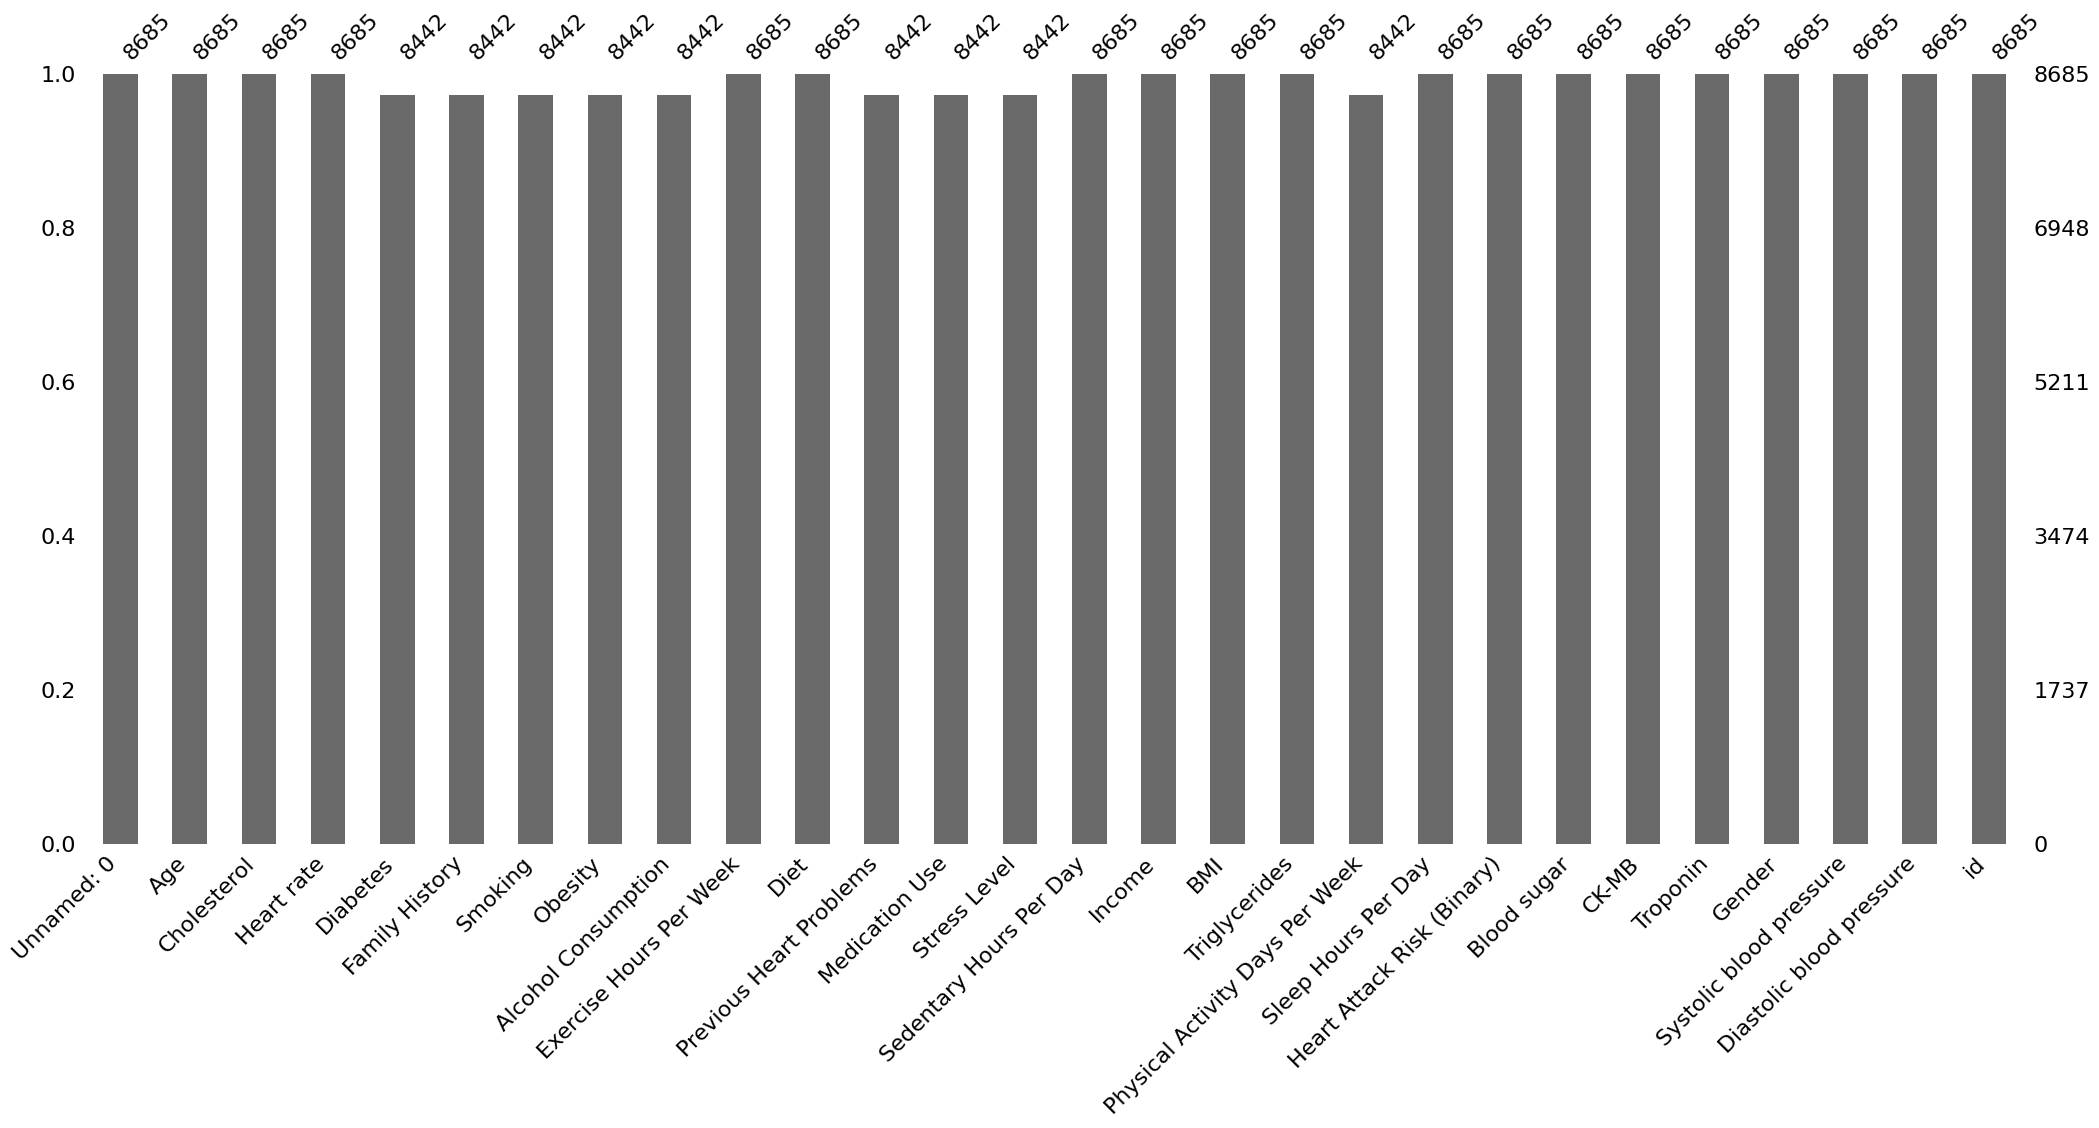

Diabetes                           243
Family History                     243
Smoking                            243
Obesity                            243
Alcohol Consumption                243
Previous Heart Problems            243
Medication Use                     243
Stress Level                       243
Physical Activity Days Per Week    243
dtype: int64

In [7]:
if train_data.isnull().sum().sum() > 0:
    msno.bar(train_data)
    plt.show()
    
    missing_data(train_data)

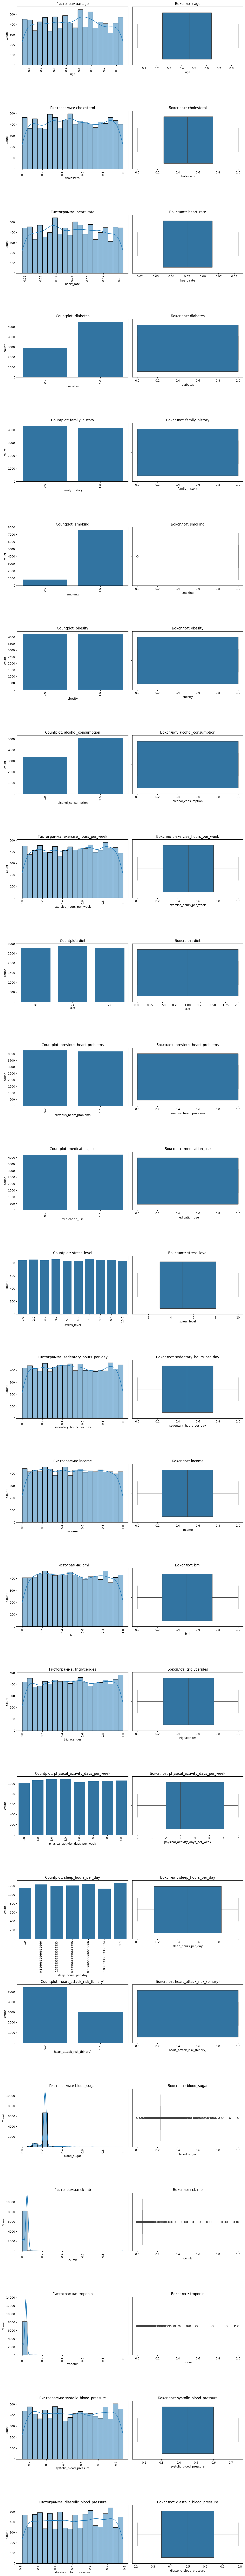

In [17]:
plot_combined(train_data, col=None, target=None, col_type=None, legend_loc='best')

In [8]:
train_data.sample(10)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
3578,3578,0.741573,0.746429,0.074244,1.0,0.0,1.0,1.0,1.0,0.832146,...,5.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.412903,0.255814,4322
3386,3386,0.044944,0.046429,0.028414,0.0,1.0,1.0,1.0,0.0,0.026353,...,7.0,1.000000,0.0,0.227018,0.048229,0.036512,Male,0.567742,0.523256,807
5413,5413,0.764045,0.207143,0.039413,0.0,0.0,1.0,0.0,1.0,0.685016,...,1.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.406452,0.337209,8767
3960,3960,0.460674,0.728571,0.043080,1.0,0.0,1.0,1.0,1.0,0.351258,...,4.0,1.000000,0.0,0.122530,0.075377,0.011457,Female,0.200000,0.697674,5938
3187,3187,0.314607,0.785714,0.054079,0.0,0.0,1.0,0.0,1.0,0.425879,...,1.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.174194,0.279070,907
4714,4714,0.719101,0.117857,0.043996,1.0,0.0,1.0,1.0,0.0,0.612792,...,3.0,1.000000,0.0,0.171937,0.001448,0.047675,Female,0.296774,0.558140,2895
7776,7776,0.629213,0.128571,0.039413,0.0,0.0,1.0,1.0,1.0,0.450784,...,1.0,0.833333,1.0,0.215415,0.006971,0.001456,Male,0.574194,0.755814,7863
4155,4155,0.831461,0.710714,0.035747,1.0,1.0,1.0,0.0,1.0,0.155428,...,0.0,0.000000,1.0,0.227018,0.048229,0.036512,Male,0.612903,0.488372,2700
2418,2418,0.505618,0.857143,0.032081,1.0,1.0,1.0,0.0,0.0,0.042630,...,4.0,0.166667,0.0,0.227018,0.048229,0.036512,Female,0.400000,0.639535,6508
49,49,0.561798,0.128571,0.051329,0.0,1.0,1.0,1.0,1.0,0.517686,...,2.0,0.166667,0.0,0.227018,0.048229,0.036512,Male,0.651613,0.325581,6711


Судя по примерам в выводе - данные уже почти все нормализованны.  
Что надо сделать:  
1) Удалить непонятный столбец, дублирующий номер строки;  
2) Названия столбцов привести к строчным буквам, пробелы заменить на нижнее подчеркивание;  
3) Удалить строки с пропусками/непонятными данными - сердце это не шутки, мы не можем себе позволить заполнять пропуски случайными данными;  
4) Удалить дубликаты;  
5) Закодировать гендер OneHotEncoder;  
6) Обобщить признаки, сделать "lifestyle_bad" (образ жизни негативный), где перемножим Smoking (курение), Obesity (ожирение), Alcohol Consumption (употребление алкоголя), Sedentary Hours Per Day (сидячие часы в день)  
7) Обобщить признаки, сделать "lifestyle_good" (образ жизни спортивный), где перемножим Exercise Hours Per Week (часы тренировок в неделю), Diet (диета), Physical Activity Days Per Week (дни активности в неделю)

In [9]:
# сразу сделаем id индексом
train_data = train_data.set_index('id', drop=True)

In [10]:
# удаляем столбец
train_data = train_data.drop(columns=['Unnamed: 0'])

In [11]:
# приводим названия к общепринятому виду
train_data = ColumnNameProcessor().clean_dataframe(train_data)

/tmp/ipykernel_1311841/2359920801.py:29: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(self.process_spaces)
/tmp/ipykernel_1311841/2359920801.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: self.process_spaces(x).lower() if isinstance(x, str) else x)


In [12]:
# в начале удаляем строки где есть хотя бы 1 пропуск
train_data = train_data.dropna()

In [13]:
# проверим, что в гендерах
train_data["gender"].unique()

array(['male', 'female'], dtype=object)

In [14]:
# можно теперь чистить дубликаты
train_data = train_data.drop_duplicates()

In [15]:
display(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 2664 to 7270
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8442 non-null   float64
 1   cholesterol                      8442 non-null   float64
 2   heart_rate                       8442 non-null   float64
 3   diabetes                         8442 non-null   float64
 4   family_history                   8442 non-null   float64
 5   smoking                          8442 non-null   float64
 6   obesity                          8442 non-null   float64
 7   alcohol_consumption              8442 non-null   float64
 8   exercise_hours_per_week          8442 non-null   float64
 9   diet                             8442 non-null   int64  
 10  previous_heart_problems          8442 non-null   float64
 11  medication_use                   8442 non-null   float64
 12  stress_level          

None